# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

# II. Maze Problem

Describe the problem. Read the following code and explain the GridWorld environment. 

In [28]:
import collections
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [7]:
file = open("grid.txt", "r")
data = file.read()
print(data)

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOGOOO
OOOOOOOOO


In [8]:
# maze example

debug = False
verbose = False


class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up
            
            my change
            ---------
            
            print env.next(0)  # left
            print env.next(1)  # right
            print env.next(2)  # up
            print env.next(3)  # down

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state
            
        if self.check_state(s) == 'O':
            #self._s = np.asarray(state)
            self._s = np.asarray(s)
        else:
            raise ValueError("Invalid state for init")
        

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    #Method to check if the current state is a goal state
    def goal_reached(self):
        if(self._s is not None and self._s[0]==self.goal_pos[0] and self._s[1]==self.goal_pos[1]):
            return True
        else:
            return False
        
    def get_actions(self):
        return self._actions

In [107]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'G' 'O' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


# III. Methods

In [105]:
#This method will return true only with a given probaility 

def selectRandomAction(epsilon):
    return np.random.rand()<epsilon

#A method to get the values of v for a given state
def get_V(s):
    return V[s[0],s[1]]

#A method to set a V value for a given state
def set_V(s,v):
    V[s[0],s[1]]=v
    

#Method to choose action from a state s using the estimated V values wit epsilon-greedy
def epsilon_greedy_action(env,V,epsilon=0.01):
    greedy_action=None
    Vs=[]
    for a in range(0,4):
        current_state=env._s
        env.next(a)
        Vs.append(get_V(env._s))
        env._s=current_state
    
    Vs=np.asarray(Vs)
    maxV=np.max(Vs)
    
    eqaualMax=np.where(Vs == maxV)[0]
    a=np.random.choice(eqaualMax)
    
    if(selectRandomAction(epsilon)):
        a=np.random.randint(4)
    
    return a

## TD(0) Implementation

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

#A method to learn best way to find the goal
def learn_find_goal(env,V,epsilon,alpha,gamma):
    steps=1;
    states=[]
    total_reward=0
    #Add the cureent state to the path
    while(not env.goal_reached()):
        a=epsilon_greedy_action(env,V,epsilon)
        current_state=env._s
        states.append(current_state)
        r=env.next(a)
        total_reward+=r
        #Add the nest state to the path
        
        #since the state has already been updated
        new_V=get_V(current_state)+alpha*(r+gamma*(get_V(env._s)-get_V(current_state)))
        #update the new V value for this state
        set_V(current_state,new_V)
        steps=steps+1
        
    new_V=get_V(env._s)+alpha*(r-get_V(env._s))
    set_V(env._s,new_V)
    states.append(env._s)
    return states,total_reward

## Training the agent

In [94]:
import time
#initialize the V's for each state
V=np.zeros(env._size)
env.init()
epoch_limit=3000
alpha=0.01
gamma=0.9
epsilon=0.01;
print("Learning")
rewards=[]
steps=np.zeros([epoch_limit+1,1])
for epoch in range(1,epoch_limit+1):
    #epsilon=0#epsilon-0.01*epsilon
    env.init()
    epoch_start_time=time.clock()
    states_reward=learn_find_goal(env,V,epsilon,alpha,gamma) 
    states=states_reward[0]
    rewards.append(states_reward[1])
    steps[epoch]=len(states)
    epoch_end_time=time.clock()
    if(epoch%1000==0):
        print("Epoch ",epoch)
        

Learning
Epoch  1000
Epoch  2000
Epoch  3000


# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Plot 4 plots (see the image): 
  - the sum of rewards per episode
  - the number of steps per episode
  - contour plot of Q 
  - the trajectory of solution by using the learned policy

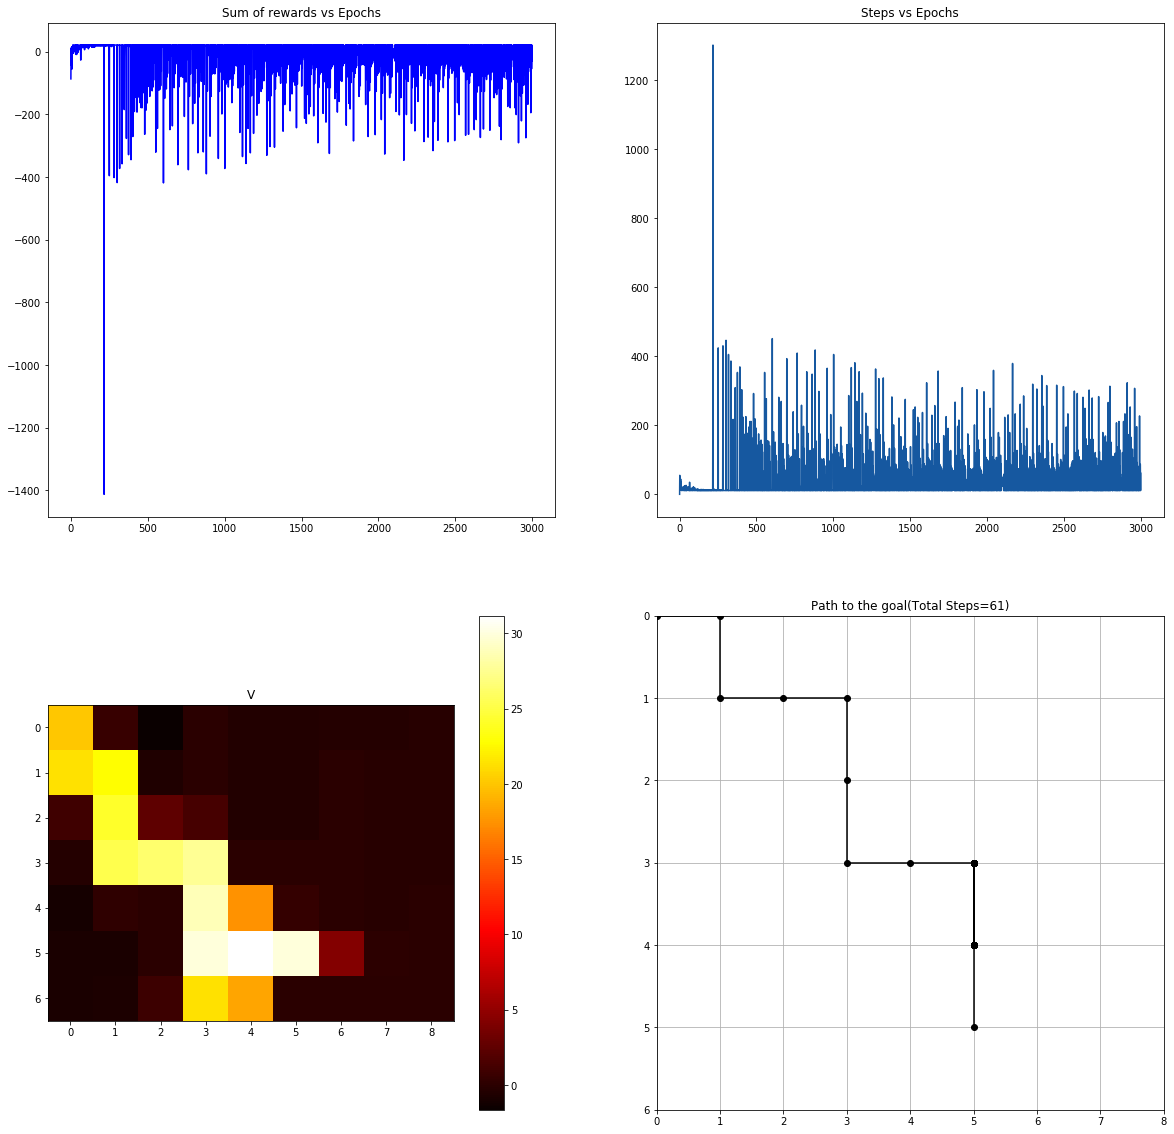

In [102]:
def plot_data(states,rewards,V,steps):
    x=[]
    y=[]
    z=[]
    state_count=0
    for state in states:
        x.append(state[0])
        y.append(state[1])
        z.append(state_count)
        state_count=state_count+1
    
   
    f, ((ax1, ax2),(ax3,ax4))=plt.subplots(2, 2,figsize=(20,20))
    
    ax1.plot(rewards,marker='', color='blue')
    ax1.set_title("Sum of rewards vs Epochs")
    
    ax2.plot(steps,marker='', color='#1658a0')
    ax2.set_title("Steps vs Epochs")
    
    heatmap =ax3.imshow(V, cmap='hot', interpolation='nearest')
    ax3.set_title("V")
    ax3.grid(False)
    
    f.colorbar(heatmap,ax=ax3)
    
    ax4.plot(x,y,marker='o', color='black')
    ax4.grid(True)
    ax4.axis([0, 8, 6, 0])
    title="Path to the goal(Total Steps="+str(len(states))+")"
    ax4.set_title(title)

plot_data(states,rewards,V,steps)

In [112]:
env.init([0,0])
#epsilon_greedy_action(env,V,epsilon)
learn_find_goal(env,V,epsilon,alpha,gamma)

([array([0, 0]),
  array([1, 0]),
  array([1, 1]),
  array([2, 1]),
  array([3, 1]),
  array([3, 2]),
  array([3, 3]),
  array([4, 3]),
  array([5, 3]),
  array([5, 4]),
  array([5, 3]),
  array([5, 4]),
  array([5, 3]),
  array([5, 4]),
  array([5, 3]),
  array([5, 4]),
  array([5, 3]),
  array([5, 4]),
  array([5, 3]),
  array([5, 4]),
  array([5, 3]),
  array([5, 4]),
  array([5, 3]),
  array([5, 4]),
  array([5, 5])],
 7)